<img src="./logo_UTN.svg" align="right" width="250" /> 

#### Teoría de Circuitos II - R4001
# Trabajo semanal 9
#### Benjamín Ithurburu

## Introducción

<img src="./Recording-ECG.jpg" align="right" width="150" style="border:10px solid white" /> 


El electrocardiograma de superficie (ECG) es una medición no invasiva del potencial eléctrico producido por el dipolo eléctrico resultante en cada célula cardíaca. Por lo general, para la medición del ECG se colocan electrodos en las extremidades del cuerpo y sobre la superficie del torso, como se aprecia en la figura. Debido a que es una técnica no invasiva y su costo no es elevado, es ampliamente utilizada en la clínica médica para conocer la funcionalidad del corazón. Habitualmente se miden entre una y doce señales de ECG dependiendo de la patología bajo análisis.


<img src="./ergo_iss.jpg" align="left" width="350" style="border:10px solid white" /> 


La señal de ECG también es afectada por los campos eléctricos generados por todas las otras fuentes biológicas del organismo bajo estudio (ruido muscular), como también por otros factores como el movimiento de los electrodos sobre la piel y el acople de la línea eléctrica (50/60 Hz) entre otros. Una de las primeras tareas previas al análisis del ECG es el filtrado de interferencias. En el siguiente ejemplo, procederemos al filtrado de un ECG registrado durante una prueba de esfuerzo o ergometría. En dichos registros, las interferencias musculares son muy exageradas dado al esfuerzo físico al que es sometido el paciente.


Para tal fin, se procede a procesar la señal de ECG con diferentes filtros recursivos, o de respuesta infinita al impulso (IIR), como también filtros no recursivos, o de respuesta finita al impulso (FIR). Dichos filtros han sido presentados en clase, por lo que en el siguiente documento evaluaremos su desempeño de forma cualitativa en señales reales.

### Experimentación

Utilizaremos un registro de ECG proveniente de una prueba ergonométrica o de esfuerzo. El mismo ha sido digitalizado a una frecuencia de muestreo de 1000 Hz, y se encuentra guardado en el archivo *ecg.mat*.

Los filtros digitales pueden ser clasificados como recursivos o no recursivos, aunque en la asignatura lo hacemos dependiendo del soporte temporal de la respuesta al impulso. Es decir de respuesta finita (FIR) o infinita al impulso (IIR). Durante la primera parte de la asignatura, estudiamos diferentes aproximaciones a la respuesta ideal de un filtro, como la de Butterworth, Chebyshev y Bessel. En cada caso, logramos obtener una función matemática, es decir una función transferencia en el dominio de la frecuencia compleja $T(s)$, que luego se implementa mediante un circuito electrónico analógico. Luego hemos visto que $T(s)$ puede discretizarse, y en consecuencia modelar el comportamiento de un sistema digital, o muestreado a $T_S=1/f_S$ mediante la [transformada bilineal](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/bilinear_transform.ipynb), es decir $s = 2 \, f_S \cdot \frac{z - 1}{z + 1}$

\begin{equation}
T(z) = T(s) \Big\vert_{s = 2 \,f_S \cdot \frac{z - 1}{z + 1}}
\end{equation}

Es decir, dada una sección de segundo orden (SOS) analógica

\begin{equation}
T(s) = \frac{\beta_0 + \beta_1 s + \beta_2 s^2}{\alpha_0 + \alpha_1 s + \alpha_2 s^2}
\end{equation}

su equivalente digital $T(z)$ también podrá expresarse como un cociente de polinomios en $z$, aunque como hemos visto, por razones de implementación lo haremos respecto a $z^{-1}$

\begin{equation}
T(z) = \frac{(\beta_2 K^2 - \beta_1 K + \beta_0) \, z^{-2} + (2 \beta_0 - 2 \beta_2 K^2) \,  z^{-1} + (\beta_2 K^2 + \beta_1 K + \beta_0)}
{(\alpha_2 K^2 - \alpha_1 K + \alpha_0) \, z^{-2} + (2 \alpha_0 - 2 \alpha_2 K^2) \,  z^{-1} + (\alpha_2 K^2 + \alpha_1 K + \alpha_0)}
\end{equation}
donde $K = 2f_S$.

Para luego reescribir $T(z)$ en función de los coeficientes del sistema muestreado $b_m$ y $a_n$

\begin{equation}
T(z) = \frac{Y(z)}{X(z)} = \frac{ b_2 \, z^{-2} + b_1 \,  z^{-1} + b_0 }
{a_2 \, z^{-2} + a_1 \,  z^{-1} + a_0}
\end{equation}

obteniendo también una SOS como era de esperar, dado que la transformada bilineal es una transformación conforme. Una vez obtenida nuestra $T(z)$ de orden arbitrario, solo resta partir la transferencia en subsecciones de segundo orden (SOS). Para ello, es necesario conocer tanto la [estructura](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/direct_forms.ipynb) como la forma en que nuestro paquete de software implementa las [SOS's](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/cascaded_structures.ipynb)
e. En el caso de *SciPy*, cuenta con una familia de funciones donde es muy sencillo diseñar y utilizar filtros digitales implementados como SOS's, como se verá en la implementación.

Para llegar a la implementación de nuestro filtro digital $T(z)$, se despeja $Y(z)$

\begin{equation}
Y(z) =  \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \, X(z) \, z^{-m} - \sum_{n=1}^{N} a_n \, Y(z) \, z^{-n} \right)
\end{equation}

finalmente se obtiene $y[k]$ por simple inspección sabiendo que $y[k-m] = Y(z) \, z^{-m}$

\begin{equation}
y[k] = \frac{1}{a_0} \left( \sum_{m=0}^{M} b_m \; x[k-m] - \sum_{n=1}^{N} a_n \; y[k-n] \right) \label{eq:ec_dif}
\end{equation}

Esta ecuación nos permite conocer el valor de la salida actual, y se la conoce como *ecuación de diferencias*. Esta misma ecuación es lo suficientemente general para la implementación de filtros IIR, como también de los FIR. Basta con hacer $a_n = 0$ para que la ec. \eqref{eq:ec_dif} se convierta en la convolución discreta entre $x[k]$ y la respuesta al impulso finita, dada por $b[m]=(b_0, b_1, \cdots, b_M)$. Los coeficientes $b_m$ del filtro FIR, pueden calcularse por ejemplo, mediante el [método de ventanas](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/window_method.ipynb), entre [otros](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/frequency_sampling_method.ipynb).

Como se trata de un análisis *offline* utilizando una arquitectura computacional sin limitaciones numéricas, como las provistas por las librerías SciPy y NumPy, algunos problemas relacionados a la implementación con aritmética y palabras de cuantización finitas no son tenidos en cuenta. Se refiere a los estudiantes interesados a los siguientes documentos acerca de [errores por la cuantización de coeficientes](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/quantization_of_coefficients.ipynb) y por una unidades aritméticas limitadas [(1, ](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/recursive_filters/quantization_of_variables.ipynb) [2)](http://nbviewer.jupyter.org/github/spatialaudio/digital-signal-processing-lecture/blob/master/nonrecursive_filters/quantization_effects.ipynb). También se le recomienda a los estudiantes interesados revisar las asignaturas optativas relacionadas al [Procesamiento Digital de Señales (DSP)](https://www.campusvirtual.frba.utn.edu.ar/especialidad/course/view.php?id=1070), como también al [DSP en tiempo real](https://www.campusvirtual.frba.utn.edu.ar/especialidad/course/view.php?id=300).

## Diseño de filtros

#### Inicialización

In [68]:
import scipy.signal as sig
import numpy as np
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla, group_delay
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# Formatear el eje 'y' en múltiplos de pi
def format_func(value, tick_number):
    return f'{value/np.pi:.0f}π' if value != 0 else '0'

#%% Inicialización de librerías
# Para eliminar bugs:
plt.figure(1)
plt.close(1)

fig_sz_x = 14
fig_sz_y = 8
fig_dpi = 70
fig_front_size = 15

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_front_size})

#%% Fin - Inicialización de librerías

#### Levantamiento de señal ECG registrada, para el posterior fltrado

In [57]:
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)


#### Plantilla

In [58]:
fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 1 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

### Diseño de filtro IIR butter

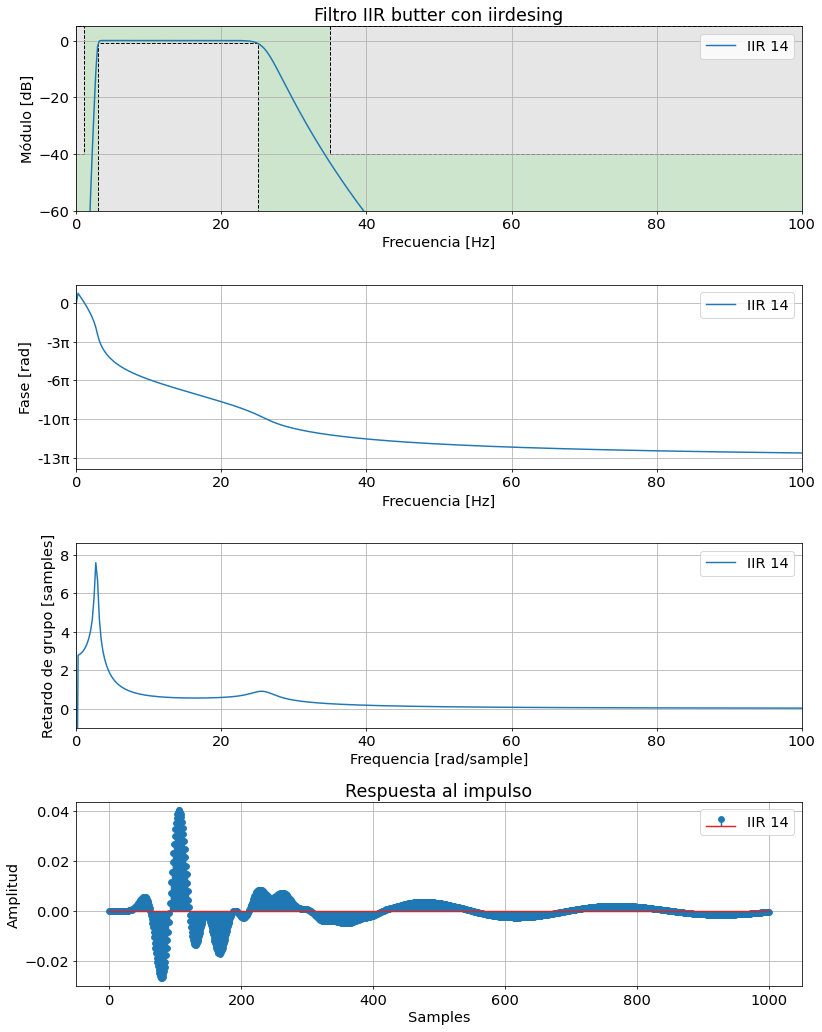

In [59]:
ba_sos_iir = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple , atenuacion, analog=False , ftype='butter' , output='sos' , fs=fs )
###########################################################################################################################
w, h = sig. sosfreqz (ba_sos_iir, worN=2048, whole=False, fs=fs)

# Reemplazar valores cero en h para evitar log(0)
epsilon = 1e-10
h_safe = np.where(abs(h) < epsilon, epsilon, abs(h))

plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
plt.plot(w, 20 * np.log10(h_safe), label='IIR {:d}'.format(ba_sos_iir.shape[0]))
plt.title('Filtro IIR butter con iirdesing')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);
axes_hdl = plt.gca()
axes_hdl.legend()

###########################################################################################################################
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

###########################################################################################################################
plt.subplot(4, 1, 2)
phase = np.angle(h)
unwrapped_phase = np.unwrap(phase)
plt.plot(w, unwrapped_phase, label='IIR {:d}'.format(ba_sos_iir.shape[0]))

plt.xlim(0, 100)
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
###########################################################################################################################
gd = group_delay(w, unwrapped_phase)

plt.subplot(4, 1, 3)
plt.plot(w, gd, label='IIR {:d}'.format(ba_sos_iir.shape[0]))
plt.xlim(0, 100)
plt.ylim((np.min(gd[2:-2])-1, np.max(gd[2:-2])+1))
plt.ylabel('Retardo de grupo [samples]')
plt.xlabel('Frequencia [rad/sample]')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
# Crear un impulso (delta)
impulse = np.zeros(1000)
impulse[0] = 1  # Impulso unitario
h = sig.sosfilt(ba_sos_iir, impulse)

plt.subplot(4, 1, 4)
plt.stem(h, label='IIR {:d}'.format(ba_sos_iir.shape[0]))
plt.title('Respuesta al impulso')
plt.xlabel('Samples')
plt.ylabel('Amplitud')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
plt.tight_layout()
plt.show()

### Diseño de filtro FIR firls

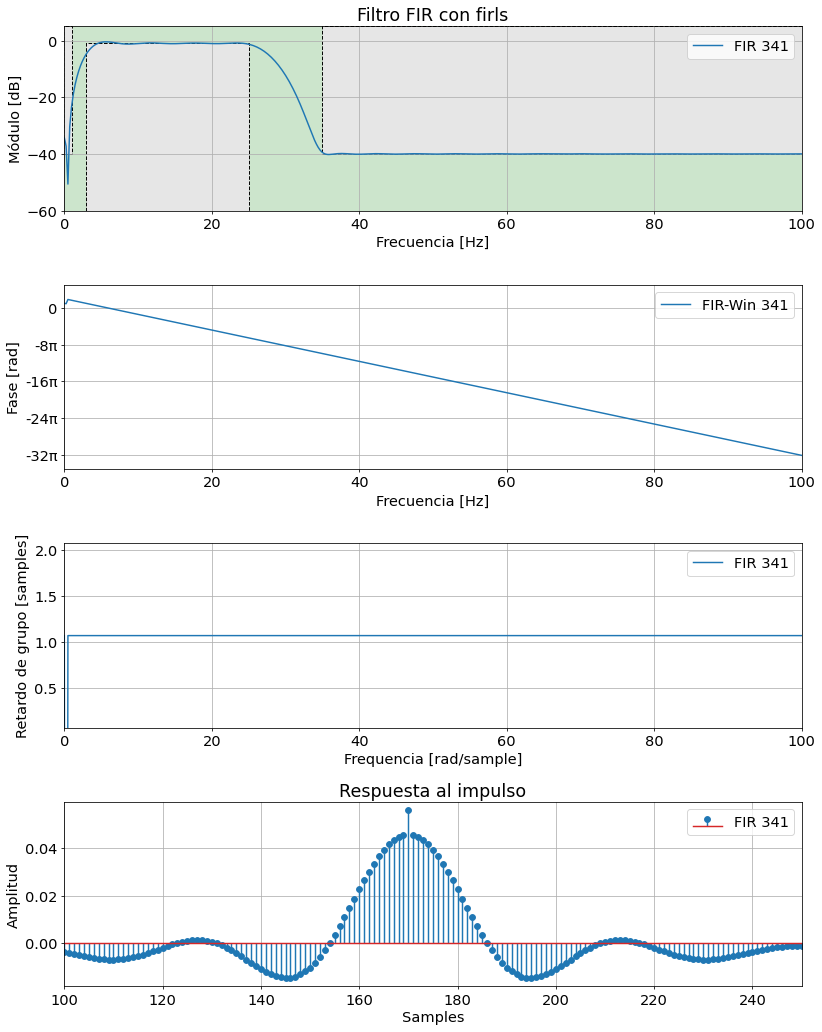

In [60]:
cant_coef = 341
a_fir = 1
b_fir = sig.firls(cant_coef, frecs*nyq_frec, gains, [100,1,1000], fs=fs)
###########################################################################################################################
w, h = sig.freqz (b_fir, a_fir, worN=2048, whole=False, fs=fs)

plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
plt.plot(w, 20 * np.log10(abs(h)), label='FIR {:d}'.format(b_fir.shape[0]))
plt.title('Filtro FIR con firls')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);
axes_hdl = plt.gca()
axes_hdl.legend()

###########################################################################################################################
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)
###########################################################################################################################
plt.subplot(4, 1, 2)
phase = np.angle(h)
unwrapped_phase = np.unwrap(phase)
plt.plot(w, unwrapped_phase, label='FIR-Win {:d}'.format(b_fir.shape[0]))

plt.xlim(0, 100)
plt.ylim(-35*np.pi, 5*np.pi)
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
###########################################################################################################################
gd = group_delay(w, unwrapped_phase)

plt.subplot(4, 1, 3)
plt.plot(w, gd, label='FIR {:d}'.format(b_fir.shape[0]))
plt.xlim(0, 100)
plt.ylim((np.min(gd[2:-2])-1, np.max(gd[2:-2])+1))
plt.ylabel('Retardo de grupo [samples]')
plt.xlabel('Frequencia [rad/sample]')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
# Crear un impulso (delta)
impulse = np.zeros(300)
impulse[0] = 1  # Impulso en t=0

# Calcular la respuesta al impulso usando lfilter
h = sig.lfilter(b_fir, a_fir, impulse)

# Graficar la respuesta al impulso
plt.subplot(4, 1, 4)
plt.stem(h, label='FIR {:d}'.format(b_fir.shape[0]))
plt.xlim(100, 250)
plt.title('Respuesta al impulso')
plt.xlabel('Samples')
plt.ylabel('Amplitud')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
plt.tight_layout()
plt.show()

### Diseño de filtro FIR de ventana

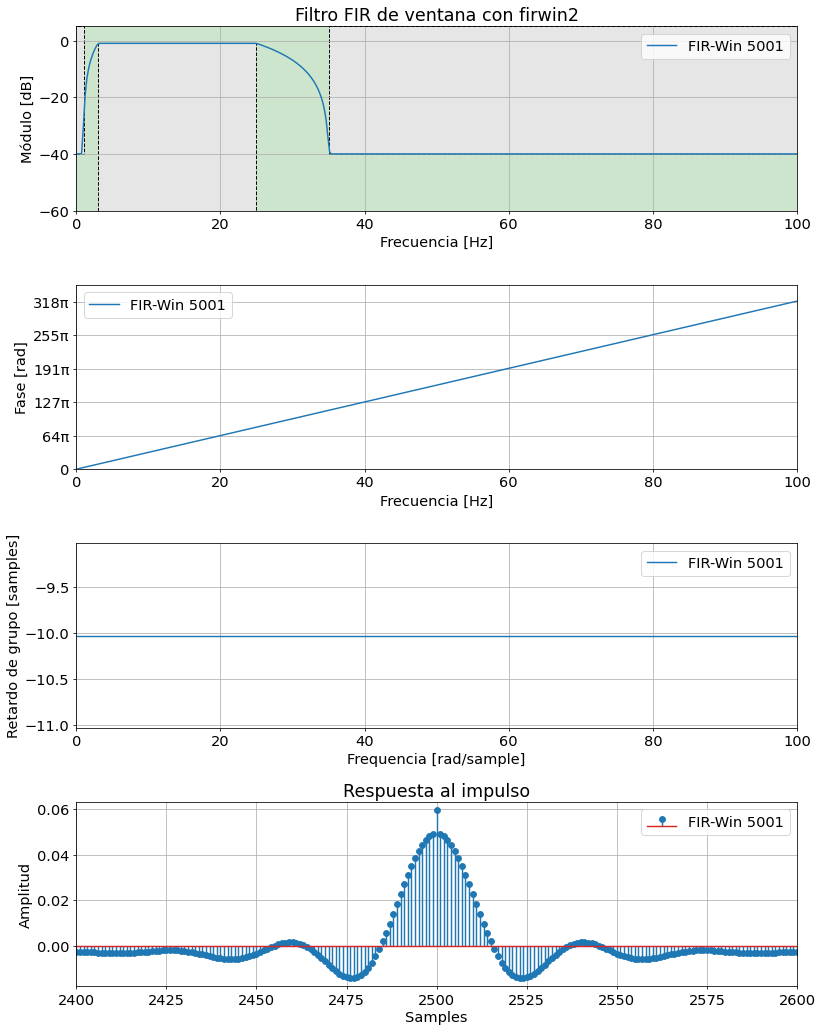

In [61]:
cant_coef = 5001
a_win = 1
b_win = sig.firwin2(cant_coef, frecs*nyq_frec, gains, nfreqs=None, window='hamming', antisymmetric=False, fs=fs)
###########################################################################################################################
w, h = sig.freqz (b_win, a_win, worN=2048, whole=False, fs=fs)

plt.figure(figsize=(12, 15))
plt.subplot(4, 1, 1)
plt.plot(w, 20 * np.log10(abs(h)), label='FIR-Win {:d}'.format(b_win.shape[0]))
plt.title('Filtro FIR de ventana con firwin2')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)
###########################################################################################################################
phase = np.angle(h)
unwrapped_phase = np.unwrap(phase)

plt.subplot(4, 1, 2)
plt.plot(w, unwrapped_phase, label='FIR-Win {:d}'.format(b_win.shape[0]))
plt.xlim(0, 100)
plt.ylim(0, 350*np.pi)
plt.ylabel('Fase [rad]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

###########################################################################################################################
gd = group_delay(w, unwrapped_phase)

plt.subplot(4, 1, 3)
plt.plot(w, gd, label='FIR-Win {:d}'.format(b_win.shape[0]))
plt.xlim(0, 100)
plt.ylim((np.min(gd[2:-2])-1, np.max(gd[2:-2])+1))
plt.ylabel('Retardo de grupo [samples]')
plt.xlabel('Frequencia [rad/sample]')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
# Crear un impulso (delta)
impulse = np.zeros(3000)
impulse[0] = 1  # Impulso en t=0

# Calcular la respuesta al impulso usando lfilter
h = sig.lfilter(b_win, a_win, impulse)

# Graficar la respuesta al impulso
plt.subplot(4, 1, 4)
plt.stem(h, label='FIR-Win {:d}'.format(b_win.shape[0]))
plt.xlim(2400, 2600)
plt.title('Respuesta al impulso')
plt.xlabel('Samples')
plt.ylabel('Amplitud')
plt.grid()
axes_hdl = plt.gca()
axes_hdl.legend()
###########################################################################################################################
plt.tight_layout()
plt.show()


## Verificación del filtrado

### Filtro IIR butter

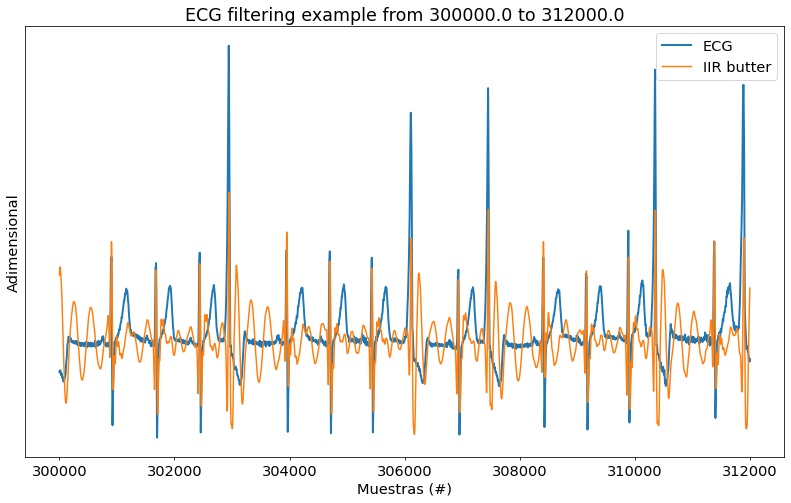

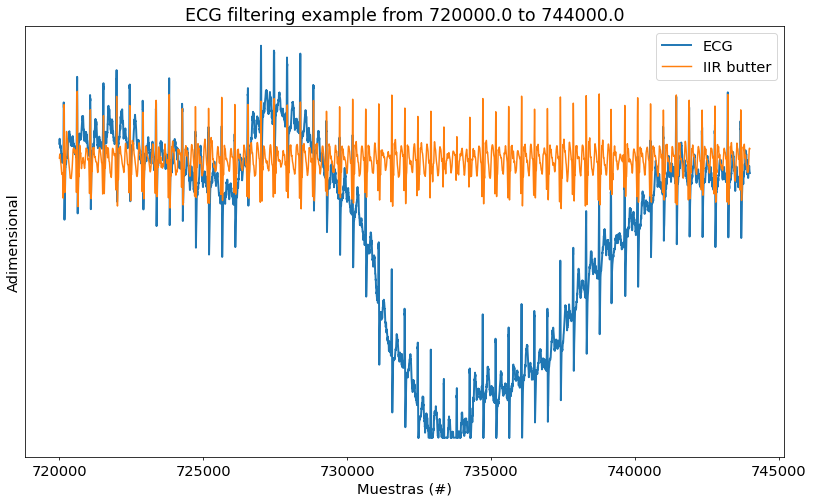

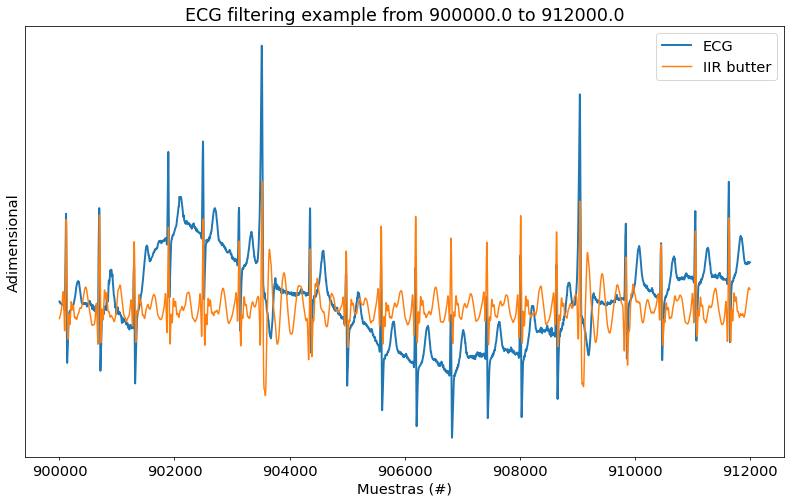

In [62]:
# IIR
ECG_f_butt = sig.sosfilt(ba_sos_iir, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora_butt = 100

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora_butt], label='IIR butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Análisis en detalle para algunos latidos con baja contaminación (banda de paso)

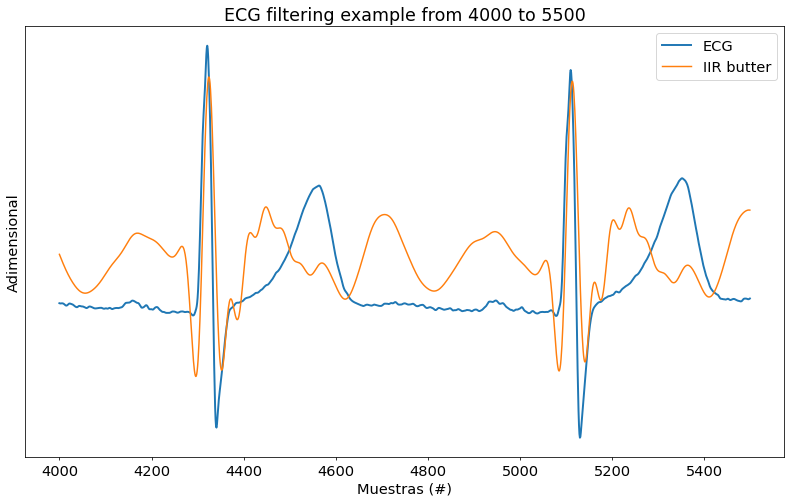

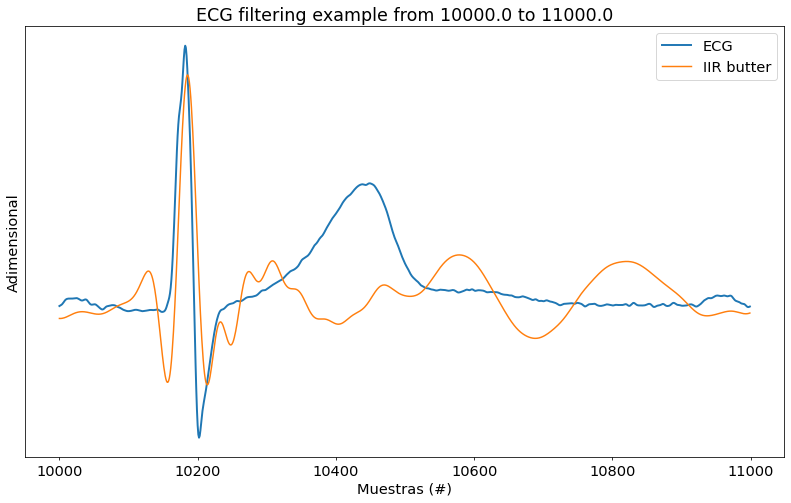

In [63]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora_butt], label='IIR butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

### Verificación filtro FIR firls

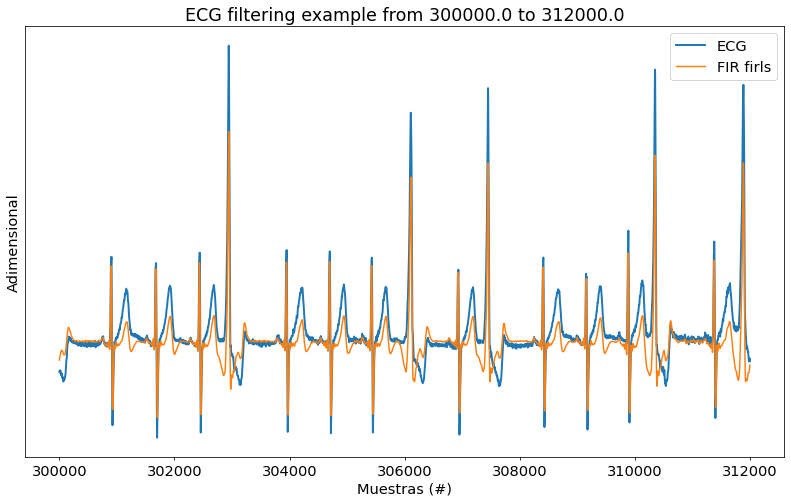

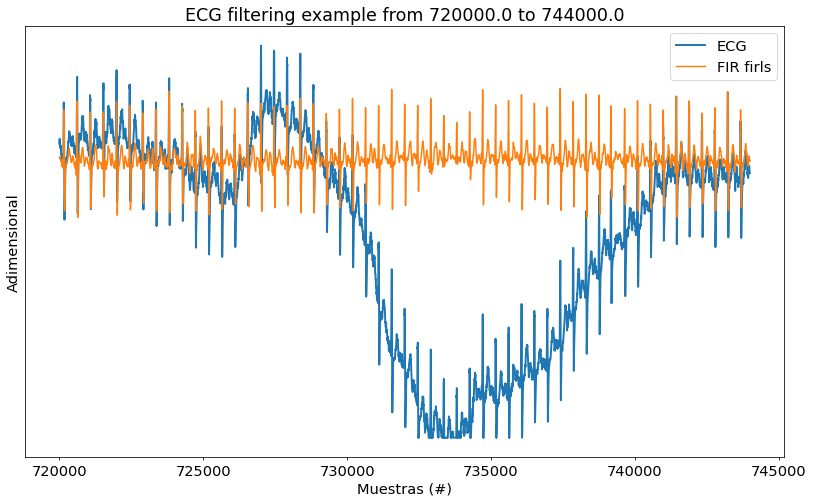

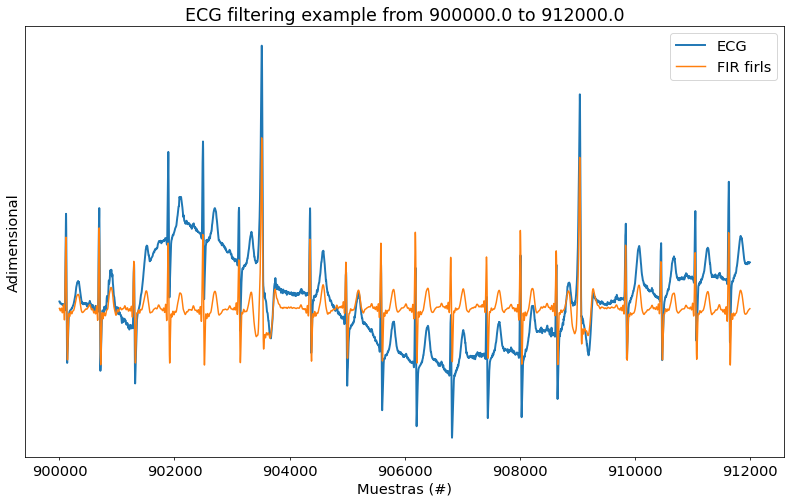

In [64]:
# FIR
ECG_f_firls = sig.lfilter(b_fir, a_fir, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora_firls = 170

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_firls[zoom_region + demora_firls], label='FIR firls')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Análisis en detalle para algunos latidos con baja contaminación (banda de paso)

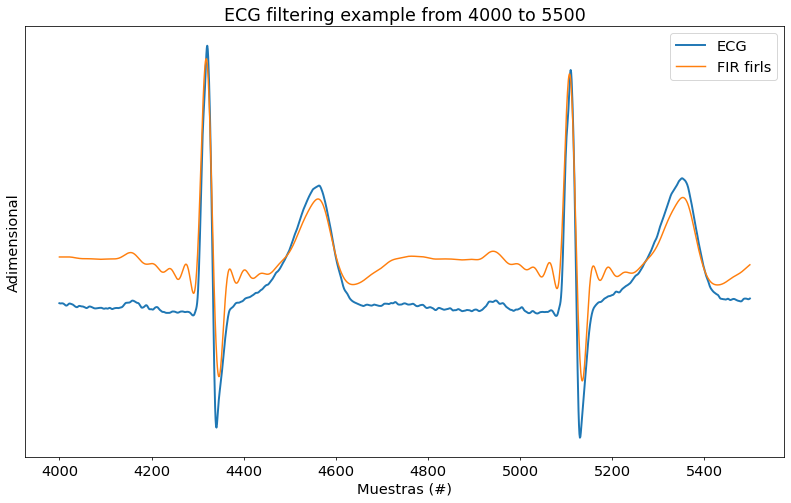

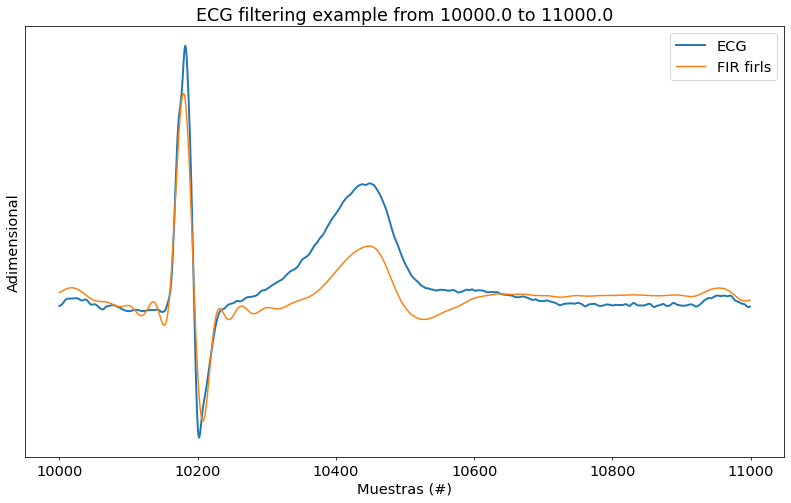

In [65]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_firls[zoom_region + demora_firls], label='FIR firls')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

### Verificación filtro FIR de ventana

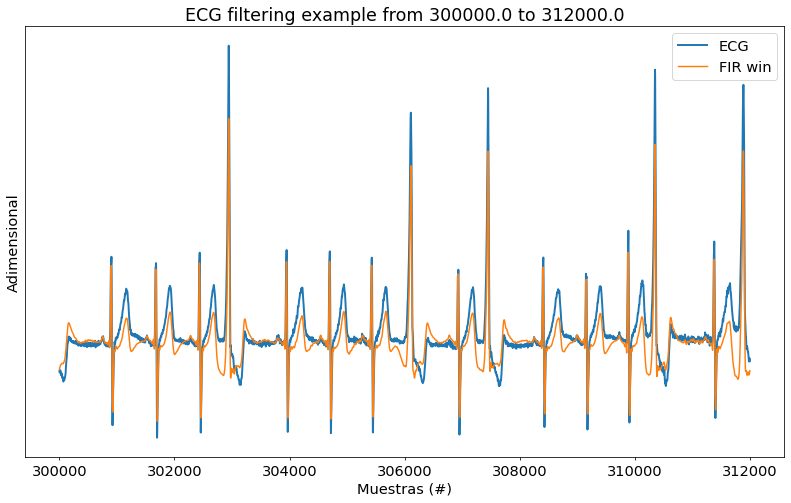

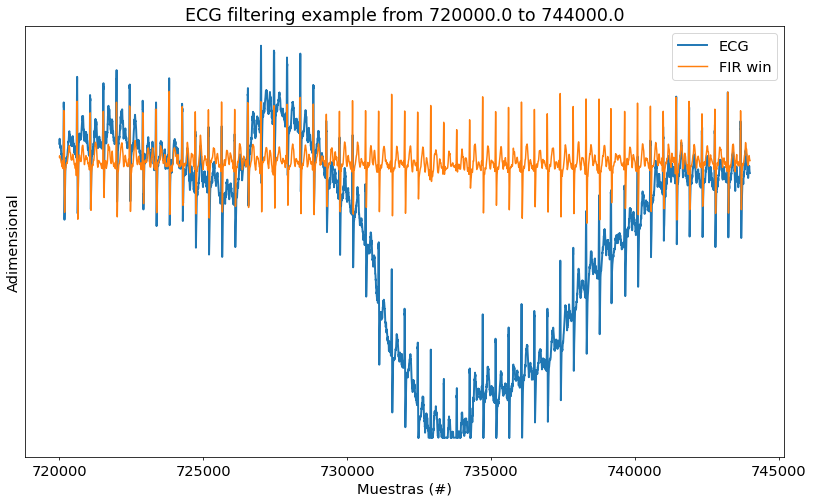

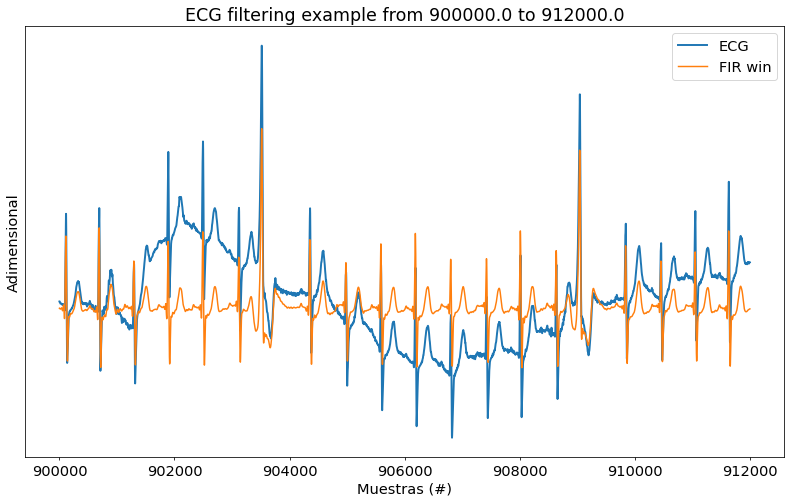

In [66]:
# FIR
ECG_f_win = sig.lfilter(b_win, a_win, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora_win = 2500

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora_win], label='FIR win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Análisis en detalle para algunos latidos con baja contaminación (banda de paso)

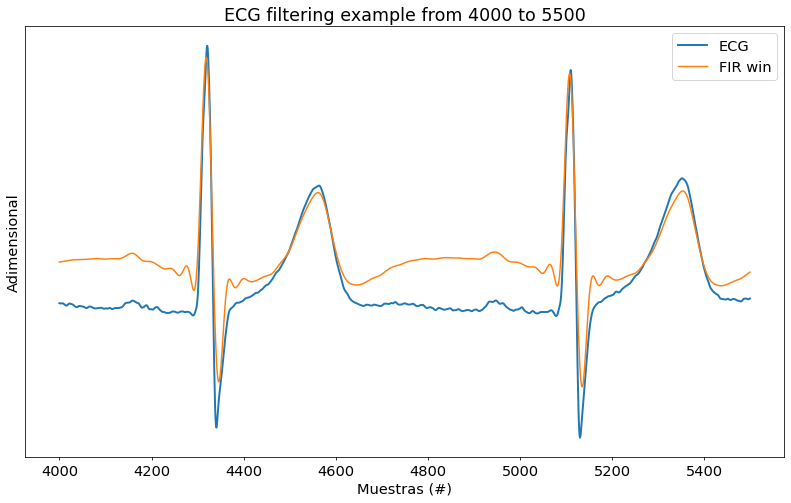

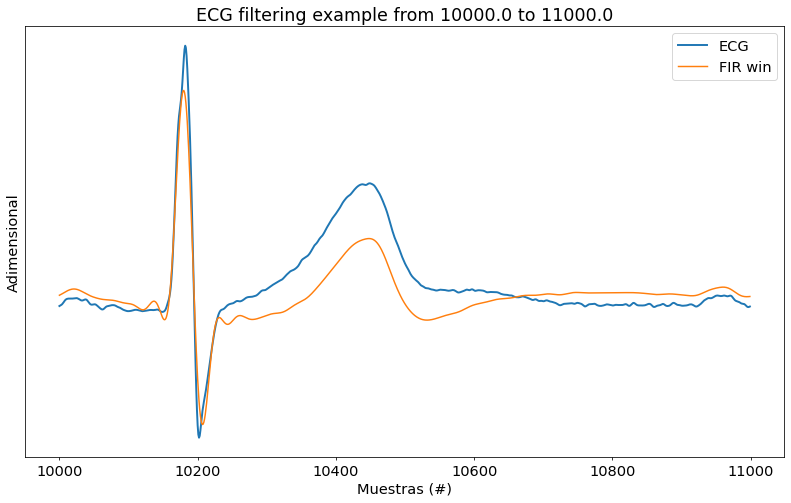

In [67]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora_win], label='FIR win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Conclusión
En el análisis del filtrado digital aplicado a la señal de un electrocardiograma (ECG), se observó que el filtro IIR Butterworth, a pesar de cumplir con los requisitos de la plantilla de diseño, presentó una mayor distorsión de la señal en comparación con los filtros FIR. Este fenómeno se atribuye a la naturaleza del filtro IIR, que, aunque realiza transiciones más abruptas y presenta un menor retardo de grupo, puede introducir distorsiones en la señal debido a su fase no lineal. Esta característica hace que el filtro IIR sea una opción adecuada para aplicaciones de filtrado en tiempo real, especialmente en situaciones donde la distorsión de información no relevante es tolerable.

Por otro lado, los filtros FIR demostraron ser más efectivos en la preservación de la forma de la señal, resultando en una menor distorsión. Sin embargo, esto se tradujo en un mayor retardo y la necesidad de un mayor número de coeficientes $b$. Dentro de los filtros FIR, se destacó el filtro de ventana, que superó al filtro de cuadrados mínimos (FIRLS) en términos de calidad de filtrado, a pesar de requerir un costo computacional adicional. Esta mejora, aunque sutil, es significativa en aplicaciones donde la integridad de la señal es crucial.

A lo largo del estudio, se corroboraron las teorías relacionadas con las características de la fase, el retardo de grupo y la respuesta al impulso tanto en filtros FIR como en filtros IIR. 

En conclusión, mientras que los filtros IIR ofrecen ventajas en términos de eficiencia temporal, los filtros FIR son preferibles cuando se requiere una mayor precisión en la representación de la señal, destacando la necesidad de seleccionar el tipo de filtro en función del contexto específico de aplicación y las características del ECG a analizar. La elección del tipo de filtro debe considerar no solo la eficiencia en la eliminación de ruido, sino también la importancia de la temporalidad y la integridad de los datos que se están procesando.

